In [206]:
import mediapipe as mp
import cv2
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import random
from sklearn import (datasets, decomposition, ensemble, 
                     metrics, model_selection, preprocessing)

In [169]:
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic
mp_hands = mp.solutions.hands

In [170]:
#Predict the body points using mediapipe model.
def mediapipe_detection(image, holistic,hands):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR to RGB
    image.flags.writeable = False                  # Image is no longer writeable
    holistic_model = holistic.process(image)                 # Make prediction
    hands_model = hands.process(image)
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    
    resize_up = cv2.resize(image, (1024,800), interpolation= cv2.INTER_AREA)

    return resize_up, holistic_model,hands_model

In [171]:
def draw_landmarks(image, pose,hands):
    if(pose.pose_world_landmarks):
        mp_drawing.draw_landmarks(image, pose.pose_world_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
            # Draw pose connections
        mp_drawing.draw_landmarks(image, pose.pose_world_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    if hands.multi_hand_landmarks:
        for hand_landmarks in hands.multi_hand_landmarks:
            mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS) # Draw hands
                # Draw right hand connections  
            mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [172]:
def convert_pose_world_to_array(hollistic):
    landmarks = hollistic.pose_world_landmarks
    data = []
    
    if(landmarks == None):
        return None
    else:
        landmarks = landmarks.landmark[11:23]
        for item in landmarks:
            if(item==None):
                data.append(None)
            else:
                landmark = {'X':item.x,'Y':item.y}
                data.append(landmark)
    return data

In [173]:
def get_left_and_right_hand_landmarks( hands):
    hands_position = hands.multi_handedness
    hands_landmarks = hands.multi_hand_world_landmarks
    
    if not hands_position:
        return [None, None]
        
    second_hand=None

    first_hand = hands_position[0].classification[0]
    if(len(hands_position) == 2):
        second_hand = hands_position[1].classification[0]

    if len(hands_position) == 1 or (second_hand and first_hand.label == second_hand.label):
        if(len(hands_position) == 2 and first_hand.score < second_hand.score):
            landmarks = hands_landmarks[1].landmark
        else:
            landmarks = hands_landmarks[0].landmark
        hand = []
        for item in landmarks:
            hand.append({'X': item.x, 'Y': item.y, 'Z': item.z})

        if hands_position[0].classification[0].label == 'Left':
            return [None,hand]

        return [hand,None]

    left_hand = []
    right_hand = []
    left_hand_landmarks = hands_landmarks[0].landmark
    right_hand_landmarks = hands_landmarks[1].landmark
    for i in range(len(left_hand_landmarks)):
        right_hand.append({'X': left_hand_landmarks[i].x, 'Y': left_hand_landmarks[i].y, 'Z': left_hand_landmarks[i].z})
        left_hand.append({'X': right_hand_landmarks[i].x, 'Y': right_hand_landmarks[i].y, 'Z': right_hand_landmarks[i].z})

    return [left_hand, right_hand]

In [174]:
# data = pd.read_json("Data.json")
# top_words = ['thank you','love','deaf',"hello","friend"]

# X_thank_you = data[data['label']=="thank you"]
# X_love= data[data['label']=="love"]
# X_deaf = data[data['label']=="deaf"]
# X_hello = data[data['label']=="hello"]
# X_friend = data[data['label']=="friend"]

# data_type = {"RIGHT_HAND_WORLD_LANDMARKS": [], "LEFT_HAND_WORLD_LANDMARKS":[],"POSE_WORLD_LANDMARKS":[],"Label":[]}
# X = np.concatenate((X_thank_you,X_love,X_deaf,X_hello,X_friend))

In [175]:
# Folder = "C:/Users/ion/Desktop/WLASL ML PROCESSING/WLASL2000/WLASL2000/"
# index = 0
# for item in X:
#     print(item)
#     print(Folder + str(item[1]).zfill(5) + ".mp4")
#     cap = cv2.VideoCapture(Folder + str(item[1]).zfill(5) + ".mp4")
#     right_hand = []
#     left_hand = []
#     pose_shape = []
#     pose_world = []
#     right_hand_world = []
#     left_hand_world = []
#     data_type["Label"].append(item[0].lower())
#     print(index)
#     index = index+1
#     with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as pose:
#         with mp_hands.Hands(min_detection_confidence=0.3,min_tracking_confidence=0.3) as hands:
#             while(cap.isOpened()):
#                 success, frame = cap.read()
#                 if(not success):
#                     break
#                 if(success):
#                     frame.flags.writeable = False
#                     image,hollistic,hands_position = mediapipe_detection(frame,pose,hands)
#                     pose_world.append(convert_pose_world_to_array(hollistic))

#                     hands_world_landmarks = get_left_and_right_hand_landmarks(hands_position)

#                     left_hand_world.append(hands_world_landmarks[0])
#                     right_hand_world.append(hands_world_landmarks[1])
                    
#     data_type["POSE_WORLD_LANDMARKS"].append(pose_world)   
#     data_type["LEFT_HAND_WORLD_LANDMARKS"].append(left_hand_world)
#     data_type["RIGHT_HAND_WORLD_LANDMARKS"].append(right_hand_world)

In [176]:
# df = pd.DataFrame.from_dict(data_type)
# df.to_json('5_words_data.json',orient='index')
df = pd.read_json('5_words_data.json',orient='index')

In [177]:
def get_removed_index_from_world_landmarks(right_hand,left_hand):
    removed_indexes = []
    # print((right_hand)==None)
    for i in range(len(right_hand)):
        if(len(right_hand) - len(removed_indexes) <=60):
            break
        if(right_hand[i] == None and left_hand[i] == None):
            removed_indexes.append(i)
    return removed_indexes

In [178]:
def convert_to_60_frames(data):
    for item in data.iterrows():
        world_remove_indexes = get_removed_index_from_world_landmarks(item[1].RIGHT_HAND_WORLD_LANDMARKS,item[1].LEFT_HAND_WORLD_LANDMARKS)

        if(len(item[1].RIGHT_HAND_WORLD_LANDMARKS)<60):
            current_length = len(item[1].RIGHT_HAND_WORLD_LANDMARKS)
            for i in range(current_length,60):
                item[1].RIGHT_HAND_WORLD_LANDMARKS.append(None)
                item[1].LEFT_HAND_WORLD_LANDMARKS.append(None)
                item[1].POSE_WORLD_LANDMARKS.append(None)

        
        for index in sorted(world_remove_indexes, reverse=True):
            del item[1].RIGHT_HAND_WORLD_LANDMARKS[index]
            del item[1].LEFT_HAND_WORLD_LANDMARKS[index]
            del item[1].POSE_WORLD_LANDMARKS[index]
            
        if(len(item[1].RIGHT_HAND_WORLD_LANDMARKS)>60):
            del item[1].RIGHT_HAND_WORLD_LANDMARKS[60:]
            del item[1].LEFT_HAND_WORLD_LANDMARKS[60:]
            del item[1].POSE_WORLD_LANDMARKS[60:]

In [179]:
sequences = []
labels = []
def extract_keypoints(pose_world_landmarks,right_hand_world_landmarks,left_hand_world_landmarks):
    pose = np.array([[res['X'], res['Y']] for res in pose_world_landmarks]).flatten() if pose_world_landmarks[0] else np.zeros(12*2)
    lh = np.array([[res['X'], res['Y'], res['Z']] for res in left_hand_world_landmarks ]).flatten() if left_hand_world_landmarks  else np.zeros(21*3)
    rh = np.array([[res['X'], res['Y'], res['Z']] for res in right_hand_world_landmarks ]).flatten() if right_hand_world_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

def convert_world_to_2d_array(data):
    k = 0
    for item in data.iterrows():
        sequence = []
        labels.append(item[1].Label)
        for i in range(len(item[1].RIGHT_HAND_WORLD_LANDMARKS)):    
            pose_world = item[1].POSE_WORLD_LANDMARKS[i]
            if pose_world == None:
                pose_world = [None]
            points = extract_keypoints(pose_world,item[1].RIGHT_HAND_WORLD_LANDMARKS[i],item[1].LEFT_HAND_WORLD_LANDMARKS[i])
            sequence.append(points)
        sequences.append(sequence)
        k= k+1

In [180]:
convert_to_60_frames(df)
convert_world_to_2d_array(df)

In [196]:

X = np.array(sequences,dtype=float)
words = np.array(labels).reshape(-1,1)
print(words)
Y = OneHotEncoder().fit_transform(words).toarray()

[['thank you']
 ['thank you']
 ['thank you']
 ['thank you']
 ['thank you']
 ['thank you']
 ['thank you']
 ['thank you']
 ['thank you']
 ['thank you']
 ['thank you']
 ['thank you']
 ['thank you']
 ['thank you']
 ['love']
 ['love']
 ['love']
 ['love']
 ['love']
 ['love']
 ['love']
 ['love']
 ['love']
 ['love']
 ['love']
 ['love']
 ['deaf']
 ['deaf']
 ['deaf']
 ['deaf']
 ['deaf']
 ['deaf']
 ['deaf']
 ['deaf']
 ['deaf']
 ['deaf']
 ['deaf']
 ['deaf']
 ['deaf']
 ['deaf']
 ['deaf']
 ['deaf']
 ['deaf']
 ['deaf']
 ['deaf']
 ['deaf']
 ['deaf']
 ['deaf']
 ['deaf']
 ['hello']
 ['hello']
 ['hello']
 ['hello']
 ['hello']
 ['hello']
 ['hello']
 ['hello']
 ['hello']
 ['hello']
 ['hello']
 ['hello']
 ['hello']
 ['friend']
 ['friend']
 ['friend']
 ['friend']
 ['friend']
 ['friend']
 ['friend']
 ['friend']
 ['friend']
 ['friend']
 ['friend']
 ['friend']
 ['friend']
 ['friend']
 ['friend']
 ['friend']]


In [182]:
def reset_random_seeds():
   tf.random.set_seed(69)
   np.random.seed(69)
   random.seed(69)


In [183]:
X.shape,Y.shape

((78, 60, 150), (78, 5))

In [186]:
X_train, X_test , y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=69,stratify = Y)

In [187]:
reset_random_seeds()


model = Sequential()
# input layer
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(60,150)))

#hidden layers
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=False, activation='relu'))

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

#output layer
model.add(Dense(Y.shape[1], activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=430,batch_size=10,validation_split = 0.2,verbose = 1)


Epoch 1/430
5/5 [==============================] - 5s 321ms/step - loss: 1.6091 - accuracy: 0.2653 - val_loss: 1.6058 - val_accuracy: 0.3846
Epoch 2/430
5/5 [==============================] - 1s 191ms/step - loss: 1.6041 - accuracy: 0.2449 - val_loss: 1.5998 - val_accuracy: 0.0769
Epoch 3/430
5/5 [==============================] - 1s 226ms/step - loss: 1.5974 - accuracy: 0.2041 - val_loss: 1.5948 - val_accuracy: 0.0769
Epoch 4/430
5/5 [==============================] - 1s 196ms/step - loss: 1.6055 - accuracy: 0.2449 - val_loss: 1.5973 - val_accuracy: 0.3846
Epoch 5/430
5/5 [==============================] - 1s 161ms/step - loss: 1.5863 - accuracy: 0.2653 - val_loss: 1.6130 - val_accuracy: 0.0769
Epoch 6/430
5/5 [==============================] - 1s 168ms/step - loss: 1.8161 - accuracy: 0.2449 - val_loss: 1.6044 - val_accuracy: 0.0769
Epoch 7/430
5/5 [==============================] - 1s 170ms/step - loss: 1.5786 - accuracy: 0.2041 - val_loss: 1.6028 - val_accuracy: 0.0769
Epoch 8/430
5

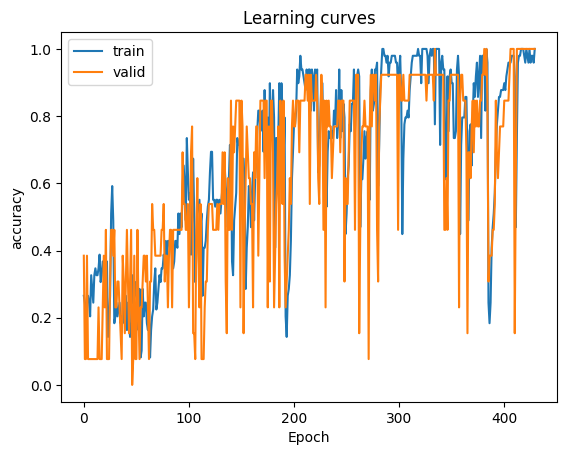

In [188]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning curves")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()
plt.show()

In [192]:
print("Accuracy on training data: {}".format(model.evaluate(X_train, y_train)))
print("Accuracy on test data: {}".format(model.evaluate(X_test, y_test)))

2/2 [==============================] - 0s 77ms/step - loss: 0.0495 - accuracy: 0.9677
Accuracy on training data: [0.04946763440966606, 0.9677419066429138]
1/1 [==============================] - 0s 53ms/step - loss: 0.0147 - accuracy: 1.0000
Accuracy on test data: [0.014696608297526836, 1.0]


In [201]:
# KNN
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

X_reshaped= X.reshape(X.shape[0], (X.shape[1]*X.shape[2]))
Y_reshaped = words.flatten()
X_train, X_test , y_train, y_test = train_test_split(X_reshaped, Y_reshaped, test_size=0.2, random_state=69,stratify = Y_reshaped)

parameters = {'n_neighbors':range(1,15,2),'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan'],
               'algorithm':['ball_tree','kd_tree','brute']}

# X_R.shape,words.shape
grid_search = GridSearchCV(KNeighborsClassifier(),parameters,cv=5,refit=True,return_train_score=True,verbose = 4)

X_train_knn,X_test_knn,Y_train_knn,Y_test_knn = train_test_split(X_train,y_train,random_state= 69,stratify = y_train)

grid_search.fit(X_train_knn,Y_train_knn)

print("Best Parameter : {}".format(grid_search.best_params_))
print("Best Cross Validation Score : {}".format(grid_search.best_score_))
print("Best estimator : {}".format(grid_search.best_estimator_))

Fitting 5 folds for each of 126 candidates, totalling 630 fits
[CV 1/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.600) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.556) total time=   0.0s
[CV 3/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.444) total time=   0.0s
[CV 4/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 5/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=1, weights=distance;, score=(train=1.000, test=0.600) total time=   0.0s
[CV 2/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=1, weights=distance;, score=(train=1.000, test=0.556) to

In [202]:
# print("Test Score : {}".format(grid_search.score(X_test_knn,Y_test_knn)))
knn = KNeighborsClassifier(algorithm= 'ball_tree', metric =  'manhattan', n_neighbors= 3, weights= 'distance')

kNN_y_pred = knn.fit(X_train, y_train).predict(X_test)
print(y_test)

In [204]:
y_test

array(['deaf', 'hello', 'love', 'deaf', 'deaf', 'deaf', 'friend', 'hello',
       'deaf', 'friend', 'thank you', 'friend', 'thank you', 'hello',
       'love', 'thank you'], dtype='<U9')

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (4).

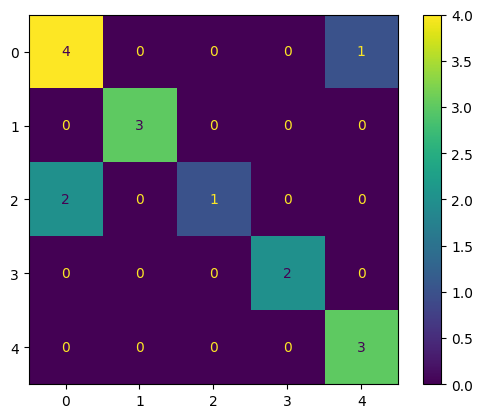

In [207]:
top_words = np.array(['thank you', 'love', 'deaf', 'hello','friend'])
actual = y_test
predicted = kNN_y_pred

confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['thank you', 'love', 'deaf', 'hello','friend'])

cm_display.plot()
plt.show()


Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted, average="weighted")
Sensitivity_recall = metrics.recall_score(actual, predicted, average="weighted")
F1_score = metrics.f1_score(actual, predicted, average="weighted")

print("Accuracy measures how often the model is correct: {}".format(Accuracy))
print("Precision measures percentage of true positive: {}".format(Precision))
print("Sensitivity is good at understanding how well the model predicts something is positive: {}".format(Sensitivity_recall))
print("F-score is the harmonic mean of precision and sensitivity. It considers both false positive and false negative cases: {}".format(F1_score))